# Week 13 Lesson: From Autoencoders to Generative AI

# Part B: Variational Autoencoders

#### Setup & Data

We'll use the Cartoon Faces dataset

In [1]:
import tensorflow as tf
print("TF:", tf.__version__)
print("Physical GPUs:", tf.config.list_physical_devices("GPU"))



TF: 2.16.1
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import time
import numpy as np
import tensorflow as tf
from pathlib import Path
import keras
from keras import layers, ops
import matplotlib.pyplot as plt
from keras import mixed_precision
mixed_precision.set_dtype_policy("mixed_float16")  # set before building the model

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# ---- Config ----
DATA_DIR   = "cartoonset100k/"
IMG_SIZE   = 128           # 32/64 for debug; 512 for full res (see PAD_TO_512)
BATCH_SIZE = 256
VAL_FRAC   = 0.10
TOTAL_MAX  = 20_000        # None = use all
PAD_TO_512 = True         # when IMG_SIZE==512, pad native 500->512
LATENT_DIM = 16

SEED = 42
rng  = np.random.default_rng(SEED)

# ---- File list ----
all_pngs = sorted([str(p) for p in Path(DATA_DIR).rglob("*.png")] +
                  [str(p) for p in Path(DATA_DIR).rglob("*.PNG")])
if TOTAL_MAX is not None:
    idx = rng.permutation(len(all_pngs))[:TOTAL_MAX]
    all_pngs = [all_pngs[i] for i in idx]

n_total = len(all_pngs)
n_val   = max(1, int(round(VAL_FRAC * n_total)))
perm    = rng.permutation(n_total)
val_paths   = [all_pngs[i] for i in perm[:n_val]]
train_paths = [all_pngs[i] for i in perm[n_val:]]

# ---- Decode/resize (with safe clipping) ----
def _decode_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=4)
    img = img[..., :3]                                  # drop alpha
    img = tf.image.convert_image_dtype(img, tf.float32) # [0,1]

    if PAD_TO_512 and IMG_SIZE == 512:
        h = tf.shape(img)[0]; w = tf.shape(img)[1]
        pad_h = tf.maximum(0, 512 - h); pad_w = tf.maximum(0, 512 - w)
        pad_top = pad_h // 2; pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2; pad_right = pad_w - pad_left
        img = tf.pad(img, [[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], mode="REFLECT")
        img = tf.image.resize(img, [512, 512], antialias=True)
    else:
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], antialias=True)

    # Numeric safety: kill tiny overshoots/undershoots from interpolation
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img  # float32 in [0,1]; model will cast to mixed_float16 at runtime


# ---- Dataset builder ----
def make_ds(paths, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if shuffle and len(paths) > 1:
        ds = ds.shuffle(min(10_000, len(paths)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_decode_png, num_parallel_calls=tf.data.AUTOTUNE).cache()
    ds = ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
    # Optional non-determinism for throughput:
    opts = tf.data.Options()
    opts.experimental_deterministic = False
    ds = ds.with_options(opts)
    return ds

train_ds = make_ds(train_paths, True)
val_ds   = make_ds(val_paths,   False)
 

2025-11-09 16:04:59.028844: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Ultra
2025-11-09 16:04:59.028885: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-11-09 16:04:59.028895: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-11-09 16:04:59.028912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-09 16:04:59.028924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


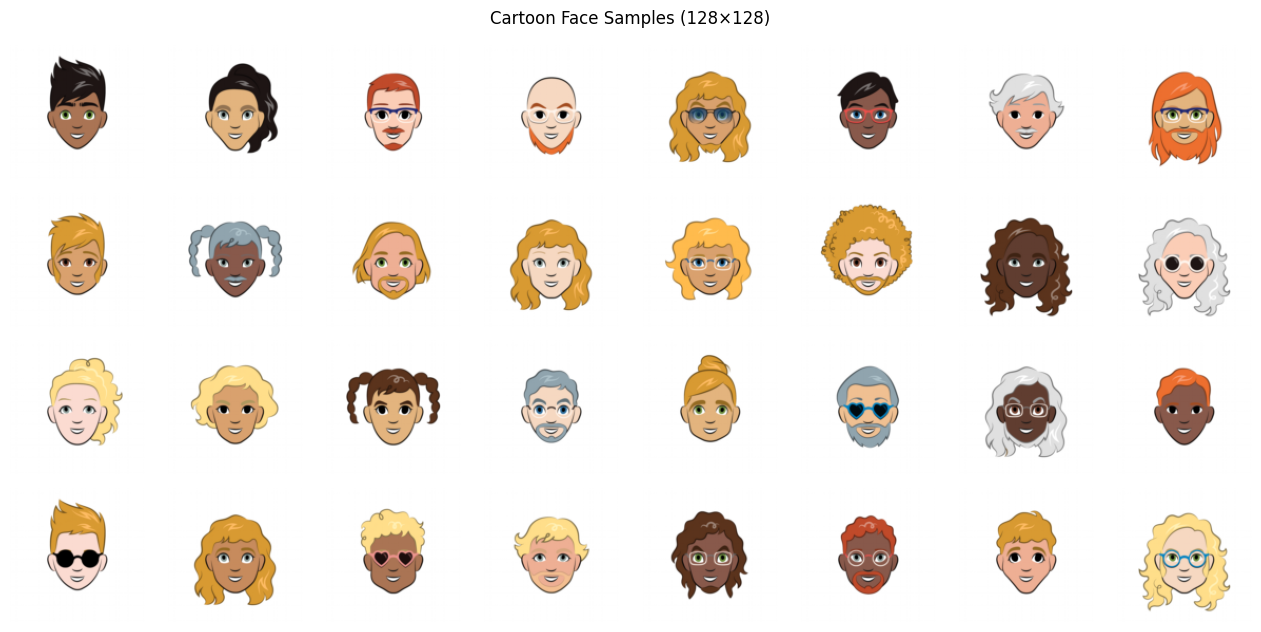

In [28]:
# ---- Quick preview: show a grid of sample faces ----
def show_samples(ds, rows=2, cols=8, title=None):
    batch = next(iter(ds))                             # (B, H, W, 3)
    x = tf.cast(batch, tf.float32).numpy()
    x = np.clip(x, 0.0, 1.0)                           # avoid matplotlib clipping warnings
    n = min(rows * cols, x.shape[0])

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.6, rows * 1.6))
    axes = np.atleast_2d(axes)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        ax.axis("off")
        if i < n:
            ax.imshow(x[i])
        else:
            ax.imshow(np.ones((IMG_SIZE, IMG_SIZE, 3)))

    if title:
        fig.suptitle(title, y=0.98, fontsize=12)
    plt.tight_layout()
    plt.show()


# Example usage:
show_samples(train_ds, rows=4, cols=8, title=f"Cartoon Face Samples ({IMG_SIZE}×{IMG_SIZE})")


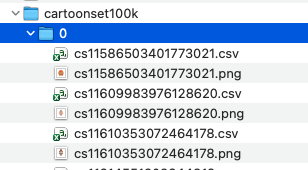

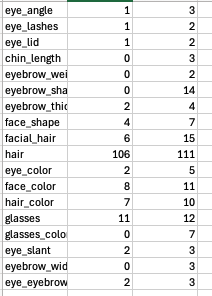

### Loss Metrics

We'll measure two types of loss, on training and on validation. 

* **`recon_loss` (reconstruction loss)**
  How well the VAE **rebuilt the input image**. We compare the input $x$ to the decoder’s output $\hat{x}$ pixel-by-pixel (in your code: BCE-with-logits, summed over pixels and averaged over the batch).
  Lower `recon_loss` ⇒ sharper/closer reconstructions.

* **`loss` (total training loss)**
  This is what the model actually optimizes. It’s the **reconstruction loss plus a regularizer** that shapes the latent space:
$$\text{loss} \;=\; \text{recon\_loss} \;+\; \beta \cdot \text{KL}(q_\phi(z|x)\,|\,\mathcal{N}(0,I)) $$


  The **KL term** encourages the encoder’s latent codes $z$ to look like a standard normal so you can sample new images by drawing $z\sim \mathcal{N}(0,I)$. The scalar $\beta$ (your warmup) controls how strong that pressure is.

**In short:** `recon_loss` = “how close is the copy?”,
`loss` = “how close is the copy **and** is the latent space nicely shaped for sampling?”


In [3]:
# --- One-cell VAE builder + trainer (stable, no KL/beta tracking in logs) ---

import time
import numpy as np
import tensorflow as tf
import keras
from keras import layers, ops

# ---------- Config (uses existing globals if present) ----------
IMG_SIZE   = globals().get("IMG_SIZE", 128)
CHANNELS   = globals().get("CHANNELS", 3)
LATENT_DIM = globals().get("LATENT_DIM", 16)

# ---------- Blocks ----------
def conv_block(x, f, k=3, s=1, act="relu"):
    return layers.Conv2D(f, k, strides=s, padding="same", activation=act)(x)

def deconv_block(x, f, up=2, k=3, act="relu"):
    x = layers.UpSampling2D(size=up, interpolation="bilinear")(x)
    x = layers.Conv2D(f, k, padding="same", activation=act)(x)
    return x

class Sampling(layers.Layer):
    def call(self, inputs, training=None):
        z_mean, z_log_var = inputs
        dtype = z_mean.dtype  # honor mixed precision
        if training is False:
            return z_mean
        eps = keras.random.normal(shape=ops.shape(z_mean), dtype=dtype)
        return z_mean + ops.exp(tf.cast(0.5, dtype) * z_log_var) * eps

# ---------- Encoder/Decoder factory ----------
def build_vae(img_size=128, channels=3, latent_dim=16, base_map=16, max_filters=256):
    # Encoder
    enc_in = keras.Input(shape=(img_size, img_size, channels))
    x = enc_in
    f = 32
    s = img_size
    while s > base_map:
        x = layers.Conv2D(f, 3, strides=2, padding="same", activation="relu")(x)
        f = min(f * 2, max_filters)
        s = (s + 1) // 2
    x = conv_block(x, f)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    z_mean   = layers.Dense(latent_dim, name="z_mean")(x)
    z_logvar = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_logvar])
    encoder = keras.Model(enc_in, [z_mean, z_logvar, z], name="encoder_vae")

    # Decoder (logits out; no final sigmoid)
    dec_in = keras.Input(shape=(latent_dim,))
    x = layers.Dense(base_map * base_map * f, activation="relu")(dec_in)
    x = layers.Reshape((base_map, base_map, f))(x)
    size = base_map
    ff = f
    while size * 2 <= img_size:
        x = deconv_block(x, ff, up=2)
        ff = max(ff // 2, 32)
        size *= 2
    if size != img_size:
        x = layers.Resizing(img_size, img_size, interpolation="bilinear")(x)
    logits = layers.Conv2D(channels, 1, padding="same", activation=None, name="logits")(x)
    decoder = keras.Model(dec_in, logits, name="decoder_vae")
    return encoder, decoder

# ---------- Build models ----------
encoder_vae, decoder_vae = build_vae(
    img_size=IMG_SIZE, channels=CHANNELS, latent_dim=LATENT_DIM, base_map=16
)

# ---------- VAE model (no KL/beta tracking in logs) ----------
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, free_bits=0.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = keras.Variable(beta, dtype="float32", trainable=False)
        self.free_bits = tf.constant(free_bits, dtype=tf.float32)

        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker]

    def call(self, x, training=False):
        z_mean, z_log_var, z = self.encoder(x, training=training)
        return self.decoder(z, training=training)  # logits

    def _recon_kl_losses(self, x, logits, z_mean, z_log_var):
        # float32 math for stability (esp. with mixed_float16)
        x         = tf.cast(x, tf.float32)
        logits    = tf.cast(logits, tf.float32)
        z_mean    = tf.cast(z_mean, tf.float32)
        z_log_var = tf.cast(z_log_var, tf.float32)

        # Reconstruction (BCE-with-logits): sum over pixels, mean over batch
        bce_map = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=logits)
        per_sample_recon = tf.reduce_sum(bce_map, axis=tuple(range(1, len(bce_map.shape))))
        recon_loss = tf.reduce_mean(per_sample_recon)

        # KL with variance clipping for stability
        z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)  # <-- stability fix
        kl_dim = -0.5 * (1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_dim = tf.maximum(kl_dim, tf.cast(self.free_bits, tf.float32))
        kl_per_sample = tf.reduce_sum(kl_dim, axis=1)
        kl_loss = tf.reduce_mean(kl_per_sample)
        return recon_loss, kl_loss

    def train_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            logits = self.decoder(z, training=True)
            recon_loss, kl_loss = self._recon_kl_losses(x, logits, z_mean, z_log_var)
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result()}

    def test_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        z_mean, z_log_var, z = self.encoder(x, training=False)
        logits = self.decoder(z, training=False)
        recon_loss, kl_loss = self._recon_kl_losses(x, logits, z_mean, z_log_var)
        total_loss = recon_loss + self.beta * kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result()}

# ---- β-VAE knobs & training setup ----
beta_start     = 1e-3
beta_end       = 1.0
warmup_epochs  = 25
epochs         = 40
free_bits      = 0.03

vae = VAE(encoder_vae, decoder_vae, beta=beta_start, free_bits=free_bits, name="vae")

def kl_warmup(epoch, logs=None):
    # linear ramp 0 → beta_end over warmup_epochs (no logging)
    progress = min(1.0, (epoch + 1) / float(warmup_epochs))
    new_beta = beta_start + (beta_end - beta_start) * progress
    vae.beta.assign(new_beta)

# Learning-rate step-down right after warmup (stability)
def step_down_lr(epoch, lr):
    return lr * 0.1 if epoch == warmup_epochs else lr

cb_warmup = keras.callbacks.LambdaCallback(on_epoch_end=kl_warmup)
cb_lr     = keras.callbacks.LearningRateScheduler(step_down_lr)
cb_es     = keras.callbacks.EarlyStopping(
    monitor="val_recon_loss", mode="min",
    patience=7, min_delta=1e-4, restore_best_weights=True
)

# Optimizer with gradient clipping (stability)
base_lr = 1e-3
opt = keras.optimizers.Adam(learning_rate=base_lr, clipnorm=1.0)

vae.compile(optimizer=opt, loss=lambda y_true, y_pred: 0.0)

# ---------- Train ----------
start = time.time()
# Expects `train_ds` / `val_ds` to yield float32 images in [0,1], shape (IMG_SIZE, IMG_SIZE, CHANNELS)
history = vae.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[cb_warmup, cb_lr, cb_es],
    verbose=1
)
end = time.time()
print(f"Elapsed training time: {time.strftime('%H:%M:%S', time.gmtime(end-start))}")


Epoch 1/40


2025-11-09 16:04:59.928353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


71/71 ━━━━━━━━━━━━━━━━━━━━ 299s 4s/step - loss: 12097.7041 - recon_loss: 12097.6465 - val_loss: 10183.7285 - val_recon_loss: 10183.6123 - learning_rate: 0.0010
Epoch 2/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 319s 4s/step - loss: 10051.3516 - recon_loss: 10038.6650 - val_loss: 9221.5146 - val_recon_loss: 9206.9736 - learning_rate: 0.0010
Epoch 3/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - loss: 9488.1445 - recon_loss: 9433.2275 - val_loss: 8855.0684 - val_recon_loss: 8774.8203 - learning_rate: 0.0010
Epoch 4/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - loss: 8383.9395 - recon_loss: 8291.7900 - val_loss: 8029.0674 - val_recon_loss: 7938.6567 - learning_rate: 0.0010
Epoch 5/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - loss: 8032.5923 - recon_loss: 7936.3643 - val_loss: 7798.9033 - val_recon_loss: 7696.5088 - learning_rate: 0.0010
Epoch 6/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - loss: 7613.0767 - recon_loss: 7521.6646 - val_loss: 7498.1304 - val_recon_loss: 7415.1382 - learning_rate: 0.0010
Epo

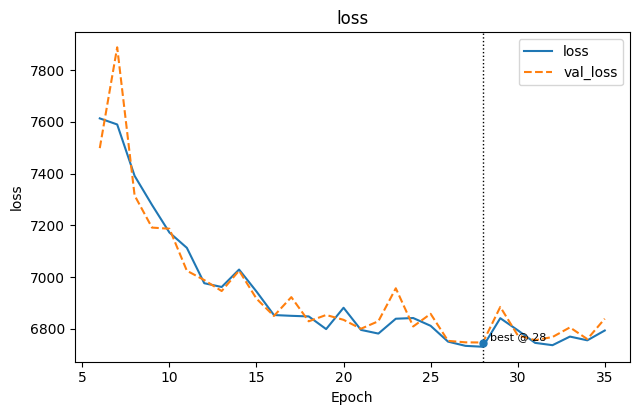

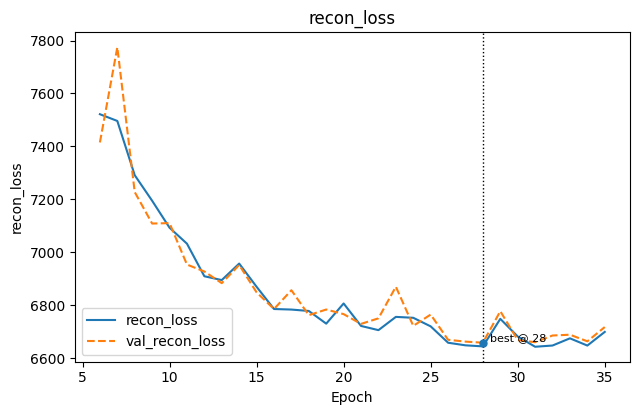

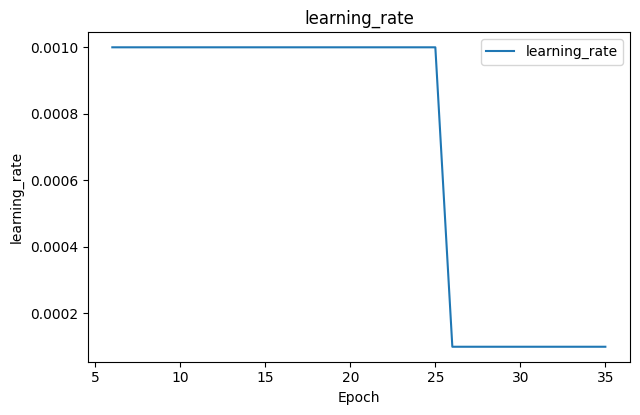

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curves(history,
                         keys=None,
                         smooth=1,
                         ema=None,
                         logy=False,
                         mark_best=True,
                         skip_first=0,
                         skip_last=0,          # ignore last M epochs
                         trim_pct=0.0,
                         ylim=None):
    H = history.history
    if keys is None:
        keys = [k for k in H.keys() if not k.startswith("val_")]

    def _ma(x, w):
        if w is None or w <= 1: return np.asarray(x, float)
        x = np.asarray(x, float)
        c = np.convolve(x, np.ones(w)/w, mode="valid")
        pad = np.full(len(x) - len(c), c[0])
        return np.concatenate([pad, c])

    def _ema(x, a):
        x = np.asarray(x, float)
        if not (a and 0 < a < 1): return x
        s = np.empty_like(x); s[0] = x[0]
        for i in range(1, len(x)): s[i] = a*x[i] + (1-a)*s[i-1]
        return s

    for k in keys:
        y_tr_all = H.get(k)
        if y_tr_all is None:
            continue
        y_va_all = H.get("val_" + k)

        # ----- slice begin/end for train -----
        y_tr_all = np.asarray(y_tr_all, float)
        n_tr = len(y_tr_all)
        end_tr = n_tr - max(0, int(skip_last))
        beg_tr = min(max(0, int(skip_first)), max(0, end_tr))
        y_tr_raw = y_tr_all[beg_tr:end_tr]

        # ----- slice begin/end for val (if present) -----
        if y_va_all is not None:
            y_va_all = np.asarray(y_va_all, float)
            n_va = len(y_va_all)
            end_va = n_va - max(0, int(skip_last))
            beg_va = min(max(0, int(skip_first)), max(0, end_va))
            y_va_raw = y_va_all[beg_va:end_va]
        else:
            y_va_raw = None

        if y_tr_raw.size == 0:  # nothing to plot after slicing
            continue

        epochs = np.arange(1 + beg_tr, beg_tr + len(y_tr_raw) + 1)

        y_tr = _ema(y_tr_raw, ema) if ema else _ma(y_tr_raw, smooth)
        y_va = None if y_va_raw is None or y_va_raw.size == 0 else (_ema(y_va_raw, ema) if ema else _ma(y_va_raw, smooth))

        plt.figure(figsize=(6.5, 4.25))
        plot = plt.semilogy if logy else plt.plot
        plot(epochs, y_tr, label=k)
        if y_va is not None:
            # If val length differs slightly, align to epochs tail/head
            m = min(len(epochs), len(y_va))
            plot(epochs[:m], y_va[:m], "--", label="val_" + k)

        if ylim is None and trim_pct and 0 < trim_pct < 1:
            data = y_tr if y_va is None else np.concatenate([y_tr[:m] if 'm' in locals() else y_tr, y_va[:m] if 'm' in locals() else y_va])
            ymax = np.nanpercentile(data, 100*trim_pct)
            ymin = np.nanpercentile(data, 100*(1-trim_pct)) if logy else np.nanmin(data)
            plt.ylim(ymin, ymax)

        if ylim is not None:
            plt.ylim(*ylim)

        if mark_best and y_va is not None and len(y_va) > 0:
            best_idx = int(np.nanargmin(y_va))
            best_idx = min(best_idx, len(epochs)-1)
            best_epoch = int(epochs[best_idx])
            plt.axvline(best_epoch, color="k", linestyle=":", linewidth=1)
            plt.scatter(best_epoch, y_va[best_idx], s=25, zorder=3)
            plt.text(best_epoch, y_va[best_idx], f"  best @ {best_epoch}", va="bottom", fontsize=8)

        plt.xlabel("Epoch"); plt.ylabel(k); plt.title(k); plt.legend(); plt.tight_layout(); plt.show()


plot_learning_curves(history, skip_first=5)

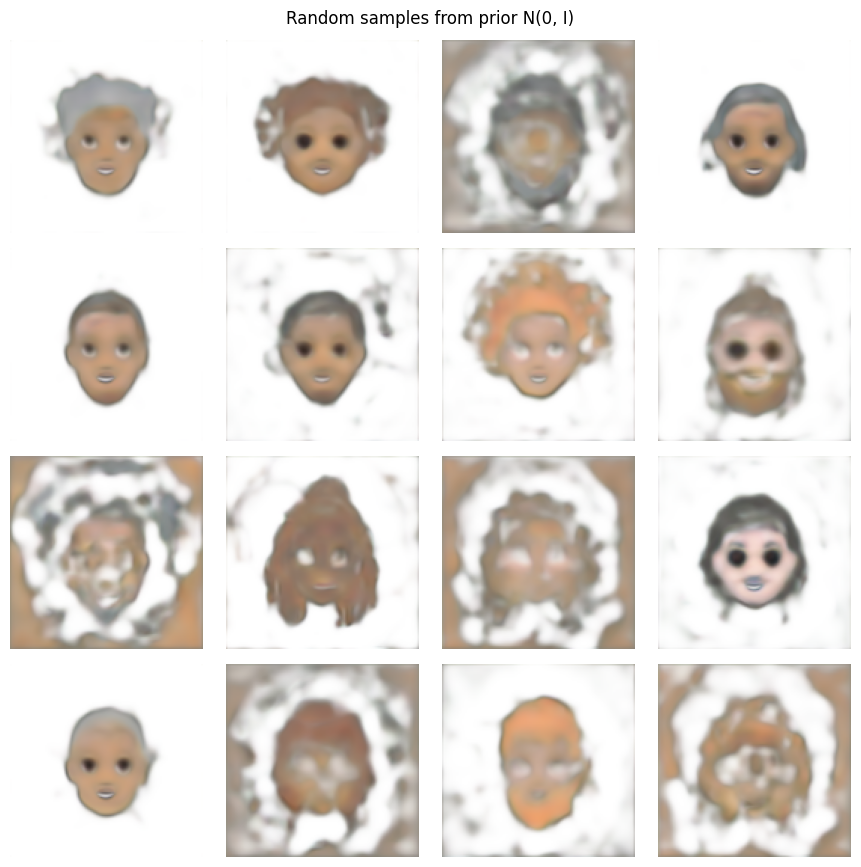

In [20]:
def demo_random_samples(decoder, latent_dim=None, n=16, to_uint8=True, seed=None, title=None):
    """
    Draw z ~ N(0,I), decode, and display a grid.
    If `seed` is None -> no fixed seed (different samples each call).
    If `seed` is an int -> deterministic samples.
    Works whether decoder returns logits or probabilities.
    """
    if latent_dim is None:
        latent_dim = int(decoder.input_shape[-1])

    # RNG: seeded iff seed is provided
    rng = np.random.default_rng() if seed is None else np.random.default_rng(seed)
    z = rng.standard_normal(size=(n, latent_dim)).astype("float32")

    out = decoder.predict(z, verbose=0)
    x = tf.convert_to_tensor(out)

    # If outputs look like logits, squash to [0,1]
    if tf.reduce_max(x) > 1.01 or tf.reduce_min(x) < -0.01:
        x = tf.math.sigmoid(x)
    x = tf.clip_by_value(x, 0.0, 1.0)

    if to_uint8:
        disp = tf.cast(tf.round(x * 255.0), tf.uint8).numpy()
        vmin, vmax = 0, 255
    else:
        disp = x.numpy()
        vmin, vmax = 0.0, 1.0

    rows = max(1, int(np.floor(np.sqrt(n))))
    cols = int(np.ceil(n / rows))
    fig, axs = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
    axs = np.atleast_1d(axs).reshape(rows, cols)

    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axs[r, c]
        if i < n:
            img = disp[i]
            if img.shape[-1] == 1:
                ax.imshow(img.squeeze(-1), cmap="gray", vmin=vmin, vmax=vmax)
            else:
                ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.axis("off")

    fig.suptitle(title or "Random samples from prior N(0, I)")
    plt.tight_layout()
    plt.show()

# Example usage:
# random each call
demo_random_samples(decoder_vae)

# deterministic
# demo_random_samples(decoder_vae, seed=123)



### Interpolation between two randomly-chosen images

2025-11-09 19:51:24.326816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


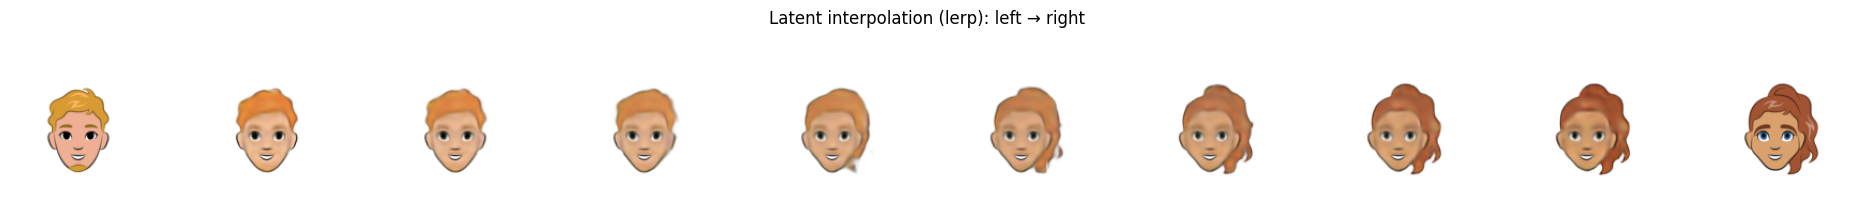

2025-11-09 19:51:24.926763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


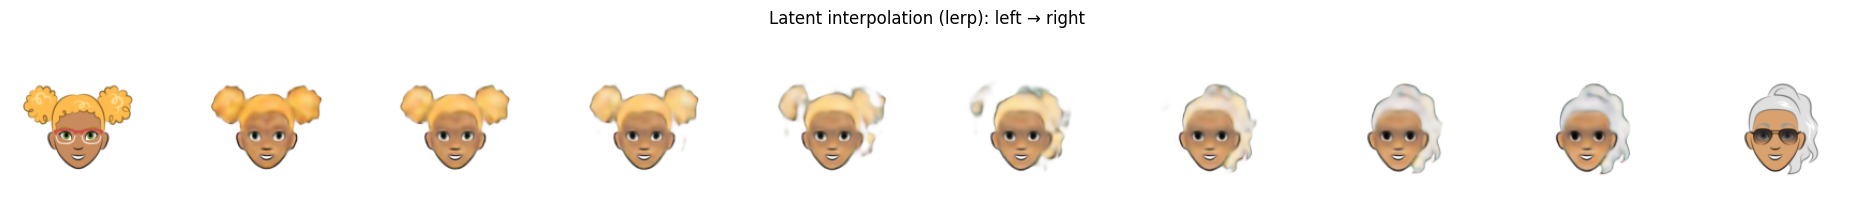

2025-11-09 19:51:25.477112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


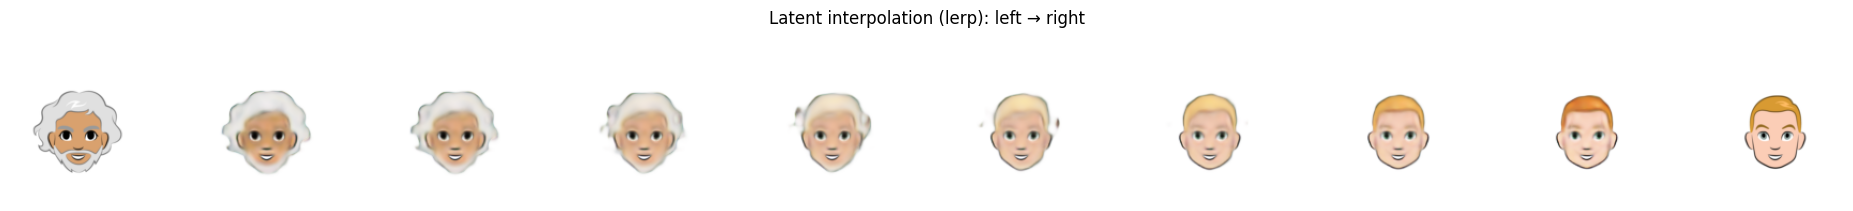

2025-11-09 19:51:26.003677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


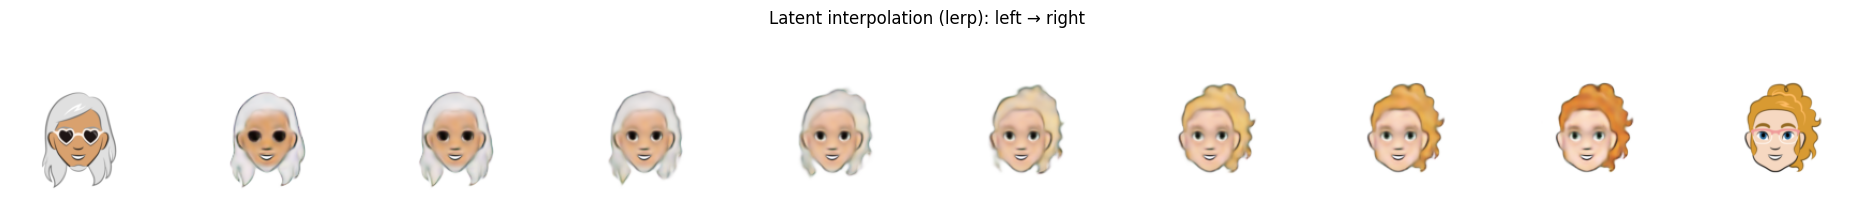

2025-11-09 19:51:26.539084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


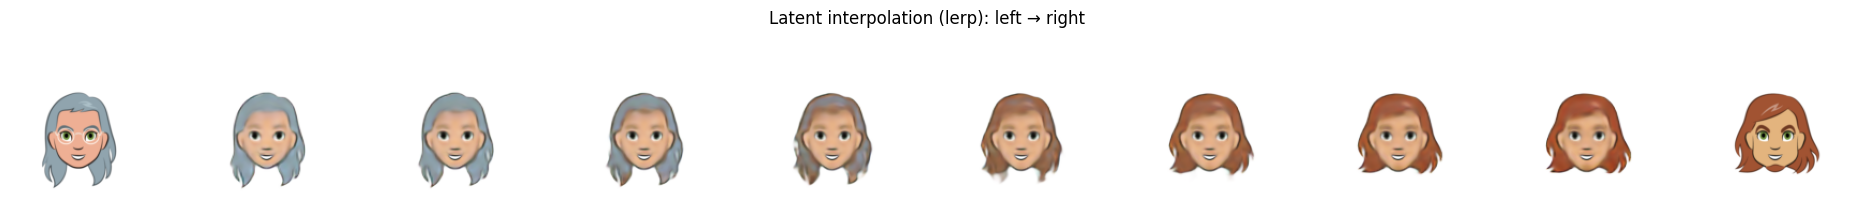

2025-11-09 19:51:27.049842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


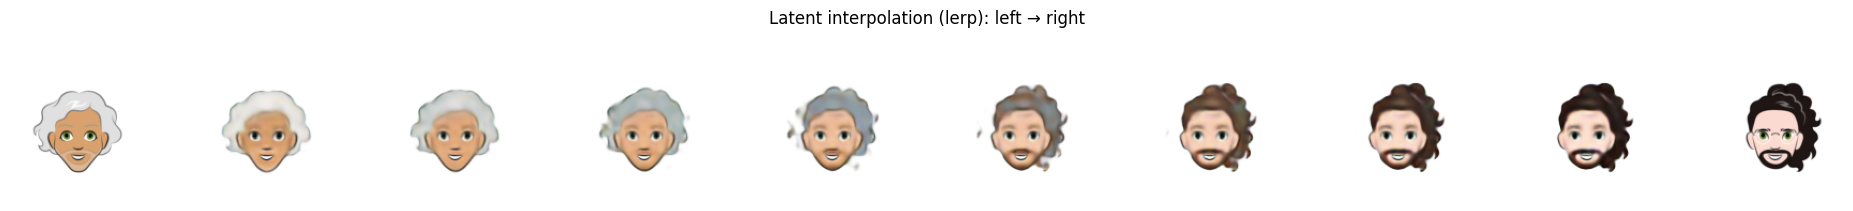

2025-11-09 19:51:27.688410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


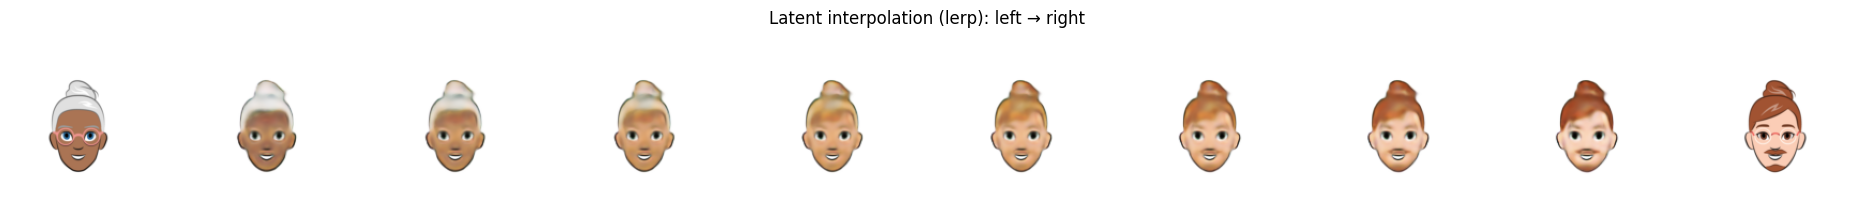

2025-11-09 19:51:28.195099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


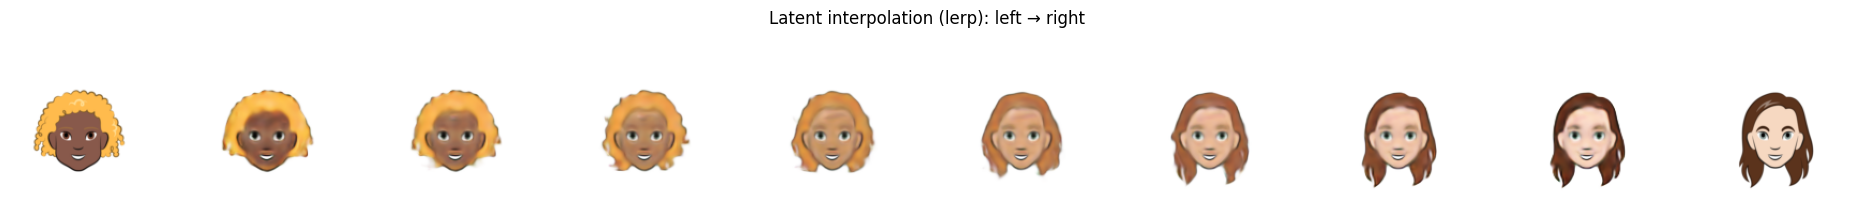

2025-11-09 19:51:28.728638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


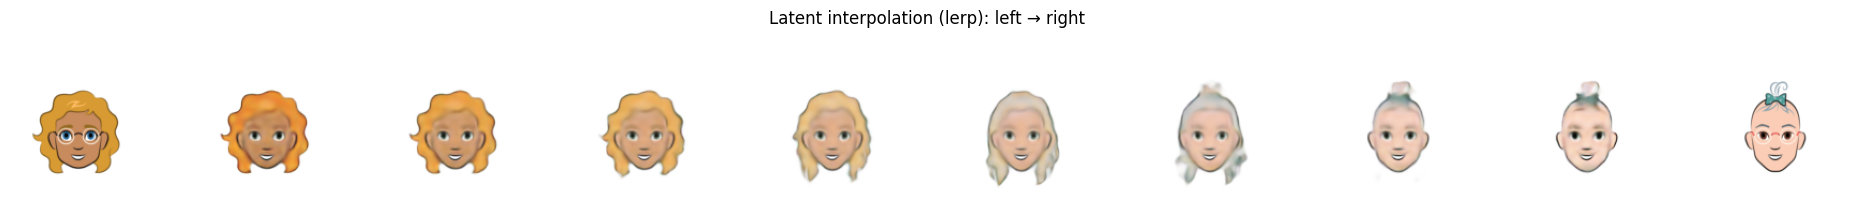

2025-11-09 19:51:29.261255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


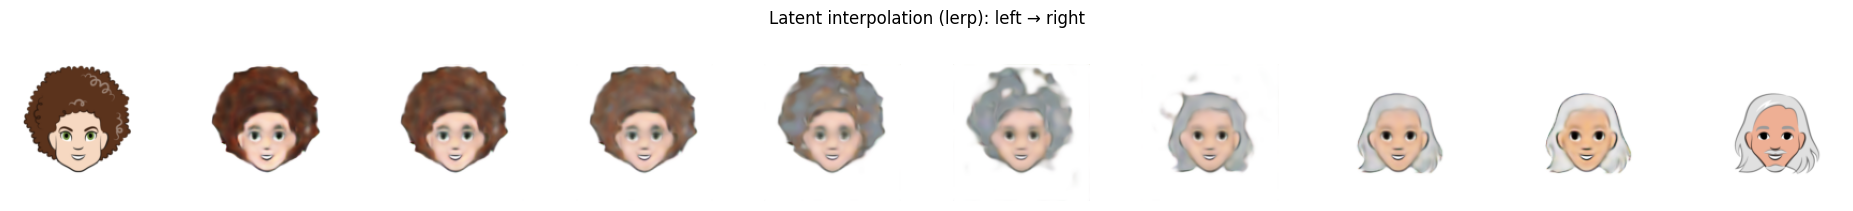

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _rng(seed=0):
    return np.random.default_rng(seed)

def _to_display(imgs, to_uint8=True):
    """
    imgs: array-like of shape (N,H,W,C). If any image looks like logits (values
    outside [0,1]), only that image gets sigmoid; others are left as-is.
    """
    x = tf.convert_to_tensor(imgs)

    # per-image decision whether to squash
    maxv = tf.reduce_max(x, axis=(1, 2, 3))
    minv = tf.reduce_min(x, axis=(1, 2, 3))
    is_logit = tf.logical_or(maxv > 1.01, minv < -0.01)

    x_list = []
    for i in range(x.shape[0]):
        xi = x[i]
        xi = tf.math.sigmoid(xi) if bool(is_logit[i].numpy()) else xi
        xi = tf.clip_by_value(xi, 0.0, 1.0)
        x_list.append(xi)
    x = tf.stack(x_list, axis=0)

    if to_uint8:
        x = tf.cast(tf.round(x * 255.0), tf.uint8)
        return x.numpy(), dict(vmin=0, vmax=255, cmap=None)
    else:
        return x.numpy(), dict(vmin=0.0, vmax=1.0, cmap=None)


def _show_row(images, title="", ncols=None, to_uint8=True):
    arr = np.stack([np.array(im) for im in images], axis=0)
    arr_disp, imshow_kwargs = _to_display(arr, to_uint8=to_uint8)
    n = arr_disp.shape[0]
    ncols = n if ncols is None else ncols
    fig = plt.figure(figsize=(1.9*ncols, 2.0))
    for i in range(n):
        ax = plt.subplot(1, ncols, i+1)
        im = arr_disp[i]
        if im.shape[-1] == 1:
            ax.imshow(im.squeeze(-1), cmap="gray",
                      vmin=imshow_kwargs["vmin"], vmax=imshow_kwargs["vmax"])
        else:
            ax.imshow(im, vmin=imshow_kwargs["vmin"], vmax=imshow_kwargs["vmax"])
        ax.axis("off")
    if title:
        fig.suptitle(title, y=1.03)
    plt.tight_layout(); plt.show()

def _encode_to_vector(encoder, x):
    out = encoder.predict(x, verbose=0)
    if isinstance(out, (list, tuple)):
        for t in out:
            if hasattr(t, "ndim") and t.ndim == 2:  # prefer z_mean
                return np.asarray(t)
        return np.asarray(out[-1])
    return np.asarray(out)

def _lerp(a, b, t):
    return (1.0 - t) * a + t * b

def _slerp(a, b, t, eps=1e-8):
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    dot = np.clip(np.dot(a, b), -1.0, 1.0)
    omega = np.arccos(dot)
    if omega < 1e-4:
        return _lerp(a, b, t)
    s0 = np.sin((1.0 - t) * omega) / np.sin(omega)
    s1 = np.sin(t * omega) / np.sin(omega)
    return s0 * a + s1 * b

# ---------- dataset-friendly sampling ----------
def _sample_two_from_ds(ds, seed=0):
    """
    Returns x0, x1 with shape (1,H,W,C), float32 in [0,1].
    Works whether ds yields images or (image, label) tuples.
    """
    # Unbatch->shuffle so we don't depend on the dataset's internal order
    ds2 = ds
    # If the dataset yields (x, y), map to x
    elem_spec = tf.nest.flatten(ds.element_spec)
    if len(elem_spec) >= 2:
        ds2 = ds2.map(lambda x, *rest: x, num_parallel_calls=tf.data.AUTOTUNE)
    ds2 = ds2.unbatch().shuffle(10_000, seed=seed, reshuffle_each_iteration=True).take(2)

    xs = [x for x in ds2.as_numpy_iterator()]
    if len(xs) < 2:
        raise ValueError("Dataset had fewer than 2 images.")
    x0, x1 = xs[0], xs[1]
    x0 = x0.astype("float32"); x1 = x1.astype("float32")
    if x0.max() > 1.01: x0 /= 255.0
    if x1.max() > 1.01: x1 /= 255.0
    # add batch dim
    return x0[None, ...], x1[None, ...]

# ---------- main demo ----------
def demo_interpolation_ds(ds, encoder, decoder, n_steps=8, seed=0,
                          mode="slerp", to_uint8=True):
    x0, x1 = _sample_two_from_ds(ds, seed=seed)

    z0 = _encode_to_vector(encoder, x0)[0]
    z1 = _encode_to_vector(encoder, x1)[0]

    ts = np.linspace(0.0, 1.0, n_steps, dtype="float32")
    if mode == "slerp":
        z_interp = np.stack([_slerp(z0, z1, float(t)) for t in ts], axis=0)
    else:
        z_interp = _lerp(z0[None, :], z1[None, :], ts[:, None])

    # Decode then sigmoid only the steps (these are logits)
    logits = decoder.predict(z_interp.astype("float32"), verbose=0)
    steps = tf.math.sigmoid(tf.convert_to_tensor(logits)).numpy()

    _show_row(
        [x0[0]] + [steps[k] for k in range(n_steps)] + [x1[0]],
        title=f"Latent interpolation ({mode}): left → right",
        ncols=n_steps + 2,
        to_uint8=to_uint8
    )


# ---------- usage with your cartoon faces dataset ----------

for k in range(10):
    demo_interpolation_ds(train_ds, encoder_vae, decoder_vae, n_steps=8, seed=k, mode="lerp")



### Denoising and Repainting Task

2025-11-09 20:08:16.415170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


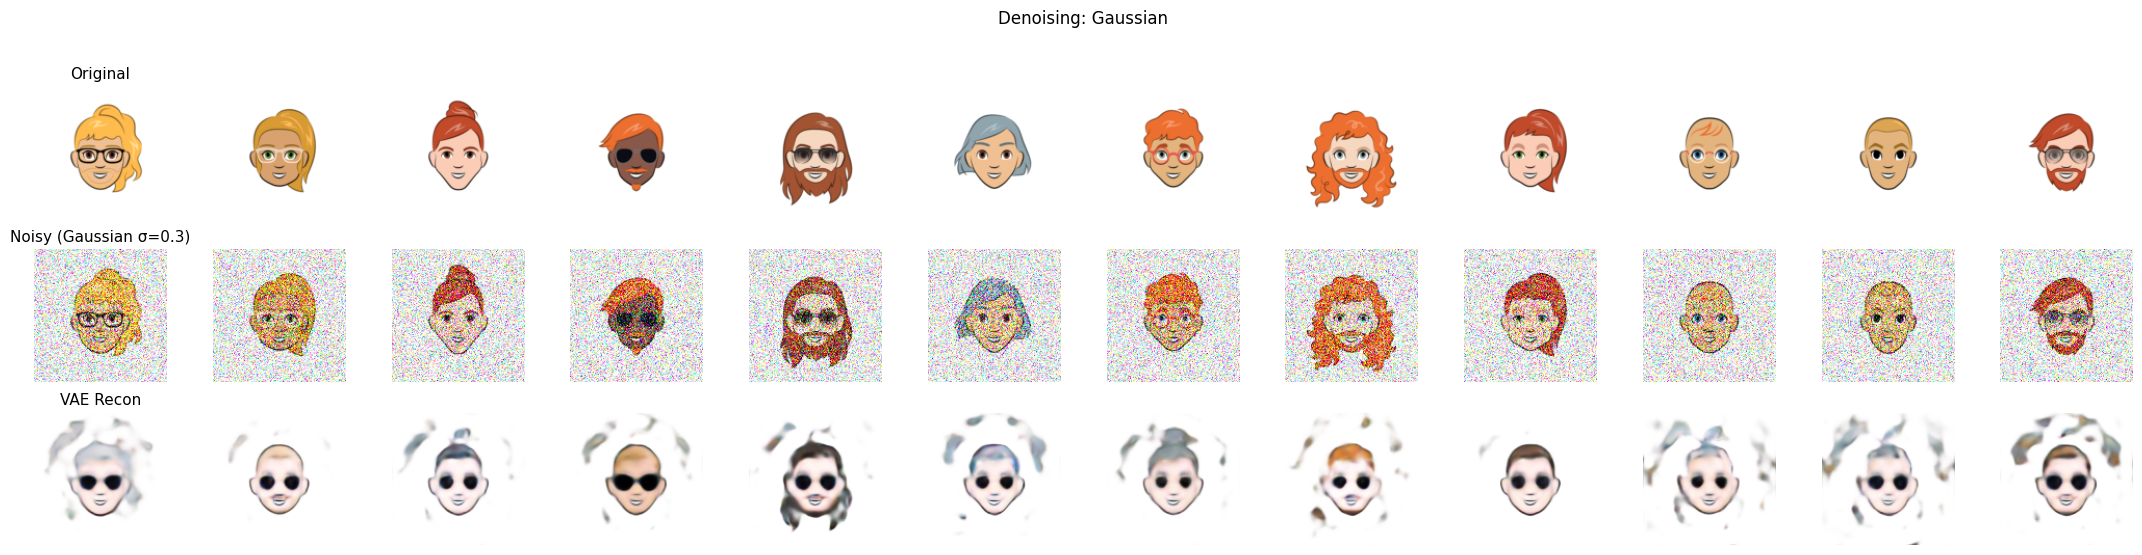

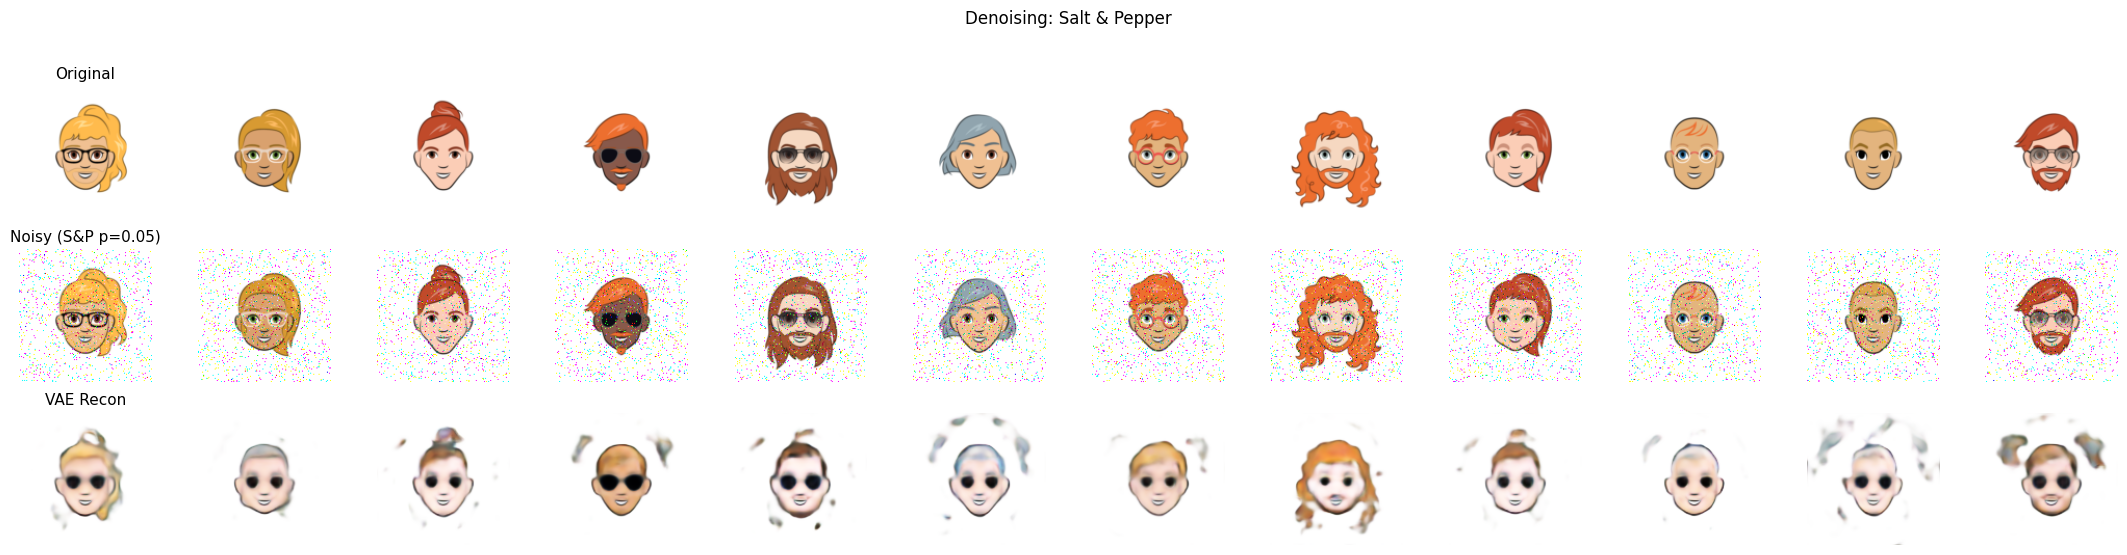

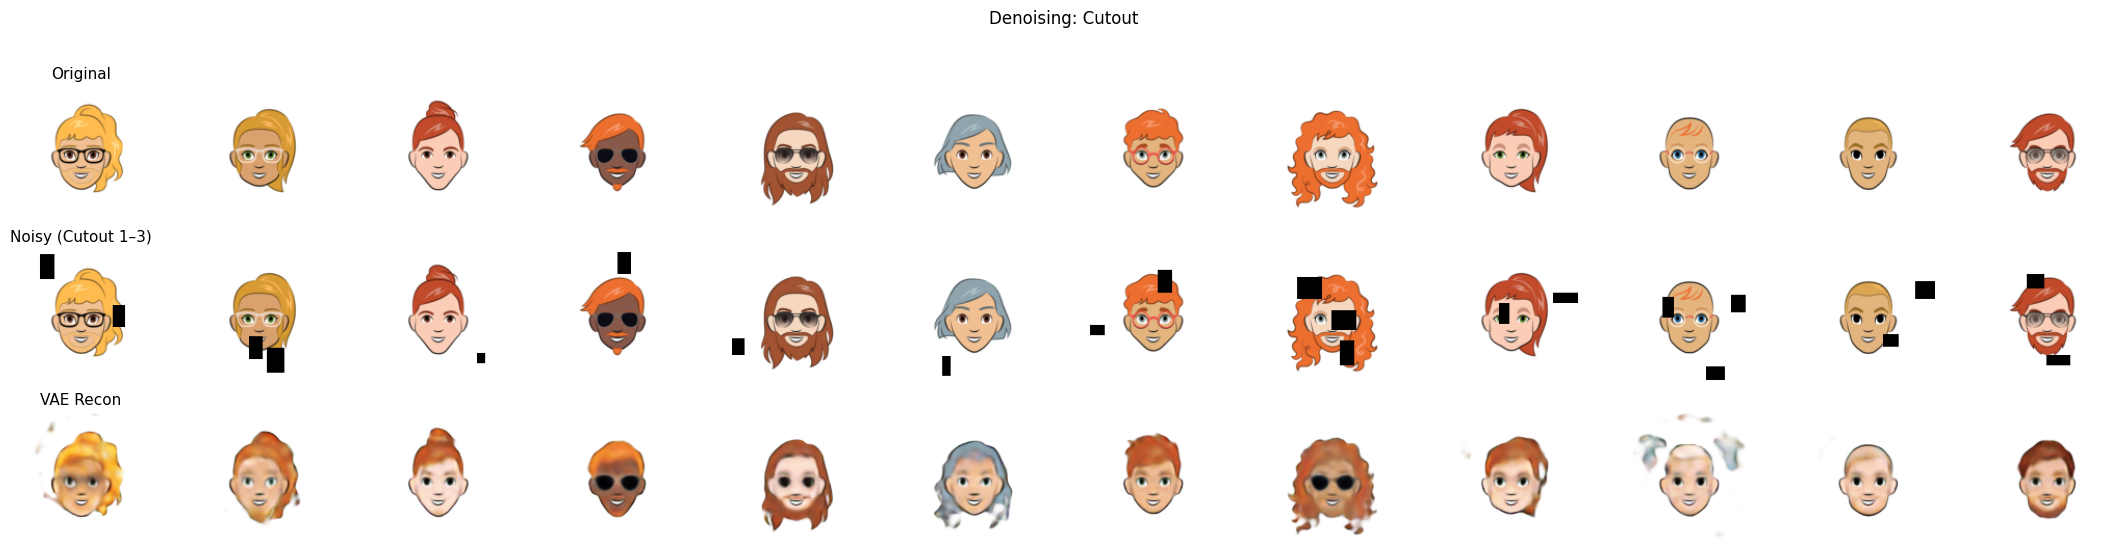

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------- dataset utils ----------
def _ds_take_n(ds, n=12, seed=7):
    """Grab N images from ds as float32 in [0,1], shape (N,H,W,C)."""
    spec = tf.nest.flatten(ds.element_spec)
    if len(spec) >= 2:  # (x, y) -> x
        ds = ds.map(lambda x, *rest: x, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.unbatch().shuffle(10000, seed=seed, reshuffle_each_iteration=False).take(n)
    X = np.stack([x.numpy() for x in ds], axis=0).astype("float32")
    if X.max() > 1.01: X /= 255.0
    return X

# ---------- noises ----------
def add_gaussian(x, sigma=0.30, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    return np.clip(x + rng.normal(0.0, sigma, x.shape).astype("float32"), 0.0, 1.0)

def add_salt_pepper(x, p=0.05, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    y = x.copy()
    m = rng.random(x.shape, dtype=np.float32)
    y[m < (p/2)] = 0.0
    y[(m >= p/2) & (m < p)] = 1.0
    return y

def add_cutout_varied(x, n_holes_range=(1,3), size_range=(8,16), rng=None):
    rng = np.random.default_rng() if rng is None else rng
    y = x.copy()
    N, H, W, C = y.shape
    for i in range(N):
        n_holes = rng.integers(n_holes_range[0], n_holes_range[1] + 1)
        for _ in range(n_holes):
            h = int(rng.integers(size_range[0], size_range[1] + 1))
            w = int(rng.integers(size_range[0], size_range[1] + 1))
            r = int(rng.integers(0, max(1, H - h + 1)))
            c = int(rng.integers(0, max(1, W - w + 1)))
            y[i, r:r+h, c:c+w, :] = 0.0
    return y

# ---------- VAE recon ----------
def vae_reconstruct(x_noisy, encoder, decoder):
    """
    Use z_mean at inference; decoder is assumed to output logits.
    """
    enc_out = encoder.predict(x_noisy, verbose=0)
    if isinstance(enc_out, (list, tuple)):
        z = None
        for t in enc_out:
            if hasattr(t, "ndim") and t.ndim == 2:  # prefer z_mean
                z = t; break
        if z is None: z = enc_out[-1]
    else:
        z = enc_out
    logits = decoder.predict(z, verbose=0)
    x_hat = tf.math.sigmoid(tf.convert_to_tensor(logits)).numpy()
    return np.clip(x_hat.astype("float32"), 0.0, 1.0)

# ---------- plotting ----------
def _to_uint8(batch):
    x = tf.clip_by_value(tf.convert_to_tensor(batch), 0.0, 1.0)
    return tf.cast(tf.round(x * 255.0), tf.uint8).numpy()

def _plot_three_rows(orig, noisy, recon, row_titles, suptitle=None, to_uint8=True):
    rows = [orig, noisy, recon]
    N = orig.shape[0]
    plt.figure(figsize=(1.8*N, 5.4))
    for r, (name, batch) in enumerate(zip(row_titles, rows)):
        disp = _to_uint8(batch) if to_uint8 else batch
        for c in range(N):
            ax = plt.subplot(3, N, r*N + c + 1)
            img = disp[c]
            if img.shape[-1] == 1:
                ax.imshow(img.squeeze(-1), cmap="gray", vmin=0, vmax=255 if to_uint8 else 1)
            else:
                ax.imshow(img)
            ax.axis("off")
            if c == 0: ax.set_title(name, fontsize=11)
    if suptitle: plt.suptitle(suptitle, y=1.02)
    plt.tight_layout(); plt.show()

# ---------- driver ----------
def demo_denoise_with_vae(ds, vae_encoder, vae_decoder,
                          n_show=12, seed=7,
                          sigma=0.30, sp_p=0.05,
                          cutout_holes=(1,3), cutout_size=(8,24)):
    rng = np.random.default_rng(seed)
    X  = _ds_take_n(ds, n=n_show, seed=seed)

    # Gaussian
    Xg  = add_gaussian(X, sigma=sigma, rng=rng)
    Vg  = vae_reconstruct(Xg, vae_encoder, vae_decoder)
    _plot_three_rows(X, Xg, Vg,
        ["Original", f"Noisy (Gaussian σ={sigma})", "VAE Recon"],
        suptitle="Denoising: Gaussian")

    # Salt & Pepper
    Xs  = add_salt_pepper(X, p=sp_p, rng=rng)
    Vs  = vae_reconstruct(Xs, vae_encoder, vae_decoder)
    _plot_three_rows(X, Xs, Vs,
        ["Original", f"Noisy (S&P p={sp_p})", "VAE Recon"],
        suptitle="Denoising: Salt & Pepper")

    # Cutout
    Xc  = add_cutout_varied(X, n_holes_range=cutout_holes, size_range=cutout_size, rng=rng)
    Vc  = vae_reconstruct(Xc, vae_encoder, vae_decoder)
    _plot_three_rows(X, Xc, Vc,
        ["Original", f"Noisy (Cutout {cutout_holes[0]}–{cutout_holes[1]})", "VAE Recon"],
        suptitle="Denoising: Cutout")

# ===== Usage =====
demo_denoise_with_vae(train_ds, encoder_vae, decoder_vae,
                      n_show=12, seed=7,
                      sigma=0.30, sp_p=0.05,
                      cutout_holes=(1,3), cutout_size=(8,24))
